# Train a Denoising Diffusion Probabilistic Model from scratch

We will train a DDPM from scratch. After training the model will be able to generate images of cars.

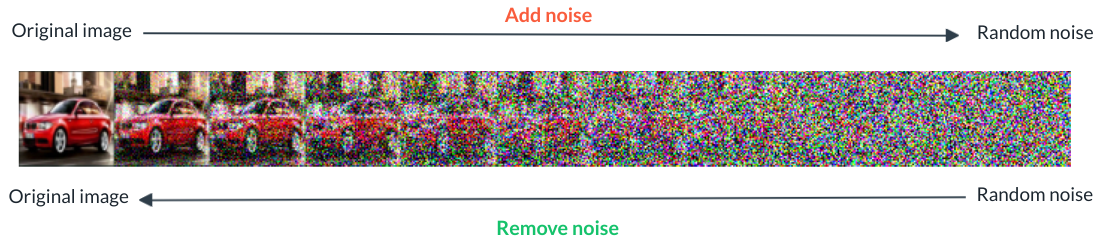

## Initial setup

Here we import a few modules and we set up the notebook so it is fully reproducible:

In [1]:
# Make results fully reproducible:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

seed = 42

random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# Import a few things we will need
import torch.nn.functional as F
import torch
from torch.optim import Adam, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR
import multiprocessing

from torchvision import transforms 
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


## Dataset

Let's start by loading our training dataset. We are going to use the Stanford Cars dataset. It consists of 196 classes of cars with a total of 16,185 images. For this exercise we do not need any label, and we also do not need a test dataset, so we are going to load both the training and the test dataset and concatenate them. We are also going to transform the images to 64x64 to test things faster:

# Setting Image and Batch Sizes

- **IMG_SIZE = 64**: This specifies that all images will be resized to 64x64 pixels. This uniform size is crucial for processing batches of images in neural networks.
- **BATCH_SIZE = 100**: During training, the dataset will be divided into batches of 100 images. Batch size impacts memory usage and can affect training dynamics and performance.

# Defining the Dataset Loader Function `get_dataset`

The function takes a `path` argument where the dataset will be stored or is located.
- `data_transform`: A series of transformations applied to each image in the dataset. These include resizing images to 64x64 pixels, randomly flipping images horizontally (which helps in augmenting the dataset for better generalization), converting images to tensors, and normalizing pixel values to the range [-1, 1]. Normalizing the data often leads to better performance as it ensures consistency in the scale of inputs.

The function loads the Stanford Cars dataset for both training and testing, applying the defined transformations. The dataset is then combined into a single dataset using `torch.utils.data.ConcatDataset`, facilitating unified handling during training and testing.

# Creating a DataLoader

The DataLoader is a PyTorch utility that loads the dataset in batches. 
- `data` variable holds the combined dataset.
- `batch_size=BATCH_SIZE` specifies how many samples per batch to load.
- `shuffle=True` ensures that the data is shuffled at every epoch, which helps in reducing overfitting by preventing the model from learning the order of the data.
- `drop_last=False` ensures that the last batch is not dropped even if it's smaller than the specified batch size, making sure no data is wasted.
- `pin_memory=True` is a performance optimization that enables faster data transfer to CUDA-enabled GPUs by pinning memory.
- `num_workers=multiprocessing.cpu_count()` sets the number of subprocesses to use for data loading to the number of CPU cores. This can improve loading efficiency.
- `persistent_workers=True` keeps the data loading workers alive between data iterations, which can improve performance by reducing the startup time of workers on each data fetch.

This cell is crucial for setting up an efficient pipeline for data preprocessing, augmentation, and loading, directly impacting the effectiveness and efficiency of the model training process.


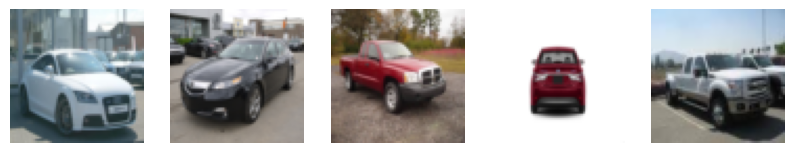

In [2]:
IMG_SIZE = 64
BATCH_SIZE = 100

def get_dataset(path):
    data_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            # We flip horizontally with probability 50%
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # Scales data into [-1,1] 
            transforms.Normalize(0.5, 0.5)
        ]
    )
    
    train = torchvision.datasets.StanfordCars(root=path, download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=path, download=True, 
                                         transform=data_transform, split='test')
    
    return torch.utils.data.ConcatDataset([train, test])

data = get_dataset("/data/stanford_cars")
dataloader = DataLoader(
    data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=False, 
    pin_memory=True, 
    num_workers=multiprocessing.cpu_count(),
    persistent_workers=True
)

def show_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        sample = dataset[i]
        image, _ = sample
        image = np.transpose(image.numpy(), (1, 2, 0))
        image = 0.5 * image + 0.5  # unnormalize
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Now let's visualize some samples from the dataset
show_images(data)

Let's look at a batch of images:

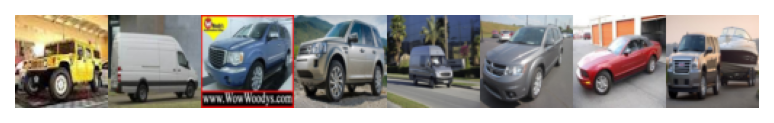

In [3]:
# Get a batch
def display_sequence(imgs, dpi=75, nrow=8):
    fig, sub = plt.subplots(dpi=dpi)
    sub.imshow(
        np.transpose(
            make_grid(
                imgs, 
                padding=0,
                normalize=True,
                nrow=nrow,
            ).cpu(),
            (1,2,0)
        )
    )
    _ = sub.axis("off")
    
    return fig

# Get a batch
batch, _ = next(iter(dataloader))

# Display it
_ = display_sequence(batch[:8], dpi=150)

## Noise scheduling and precomputation

In the forward process we need to add random noise according to a schedule. Here we use a linear schedule with 512 diffusion steps.

# Defining and Visualizing the Beta Schedule for Diffusion Process

## Defining the Beta Schedule

- **T = 512**: This sets the total number of diffusion steps in the model. Diffusion models transform data into a noise distribution over a series of steps, and T defines how many such transformations are performed.
- **betas = torch.linspace(start=0.0001, end=0.02, steps=T)**: Generates a linear sequence of beta values ranging from 0.0001 to 0.02 over T steps. These beta values are crucial in controlling the noise level added at each diffusion step. A linear schedule is a simple yet effective way to gradually increase the noise.

## Plotting the Beta Schedule

- A plot is created to visualize how the beta values change over the diffusion steps. The X-axis represents the diffusion step number, and the Y-axis represents the beta value at each step.
- `plt.plot(range(T), betas.numpy(), label='Beta Values')`: Plots the sequence of beta values. Converting betas to NumPy array format is necessary for plotting with matplotlib.
- The labels and title are set to make the plot informative.

## Key Takeaways

- **Beta Schedule**: The sequence of beta values determines how noise is added to the data at each diffusion step. It's a critical component of the diffusion process, affecting the quality and characteristics of generated samples.
- **Visualization**: Visualizing the beta schedule helps in understanding the diffusion process's dynamics. A gradual increase in beta values ensures a smooth transition from data to noise, which is essential for the model to learn the reverse process effectively (i.e., generating data from noise).

This cell is essential for setting up the diffusion model parameters and provides insights into the model's configuration, directly influencing its behavior and performance.

Let's define it:

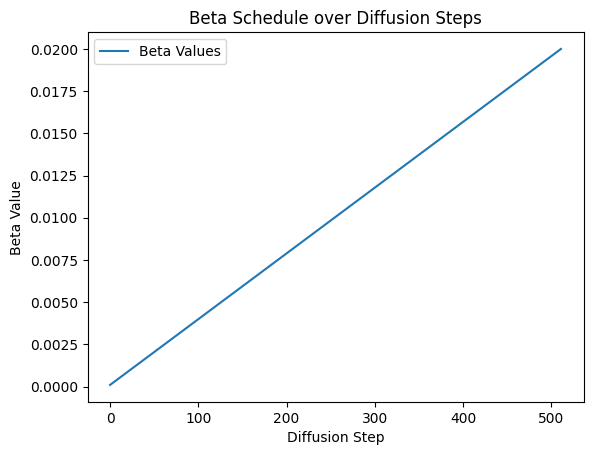

In [4]:
# Define beta schedule
T = 512  # number of diffusion steps
betas = torch.linspace(start=0.0001, end=0.02, steps=T)  # linear schedule

plt.plot(range(T), betas.numpy(), label='Beta Values')
plt.xlabel('Diffusion Step')
plt.ylabel('Beta Value')
plt.title('Beta Schedule over Diffusion Steps')
plt.legend()
plt.show()

As we have seen in the lesson, we need to use a re-parametrization of the forward process that allows us to generate noisy images at any step without having to sequentially go through all the previous steps:

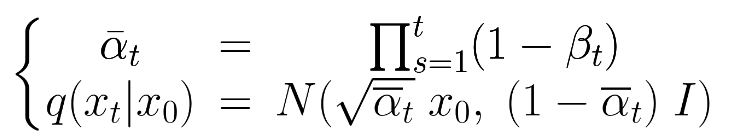

At inference time we will also need the quantities involved in these other formulas:

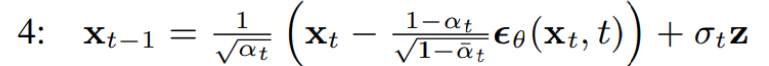
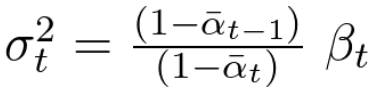

Here we define and precompute all these constants:

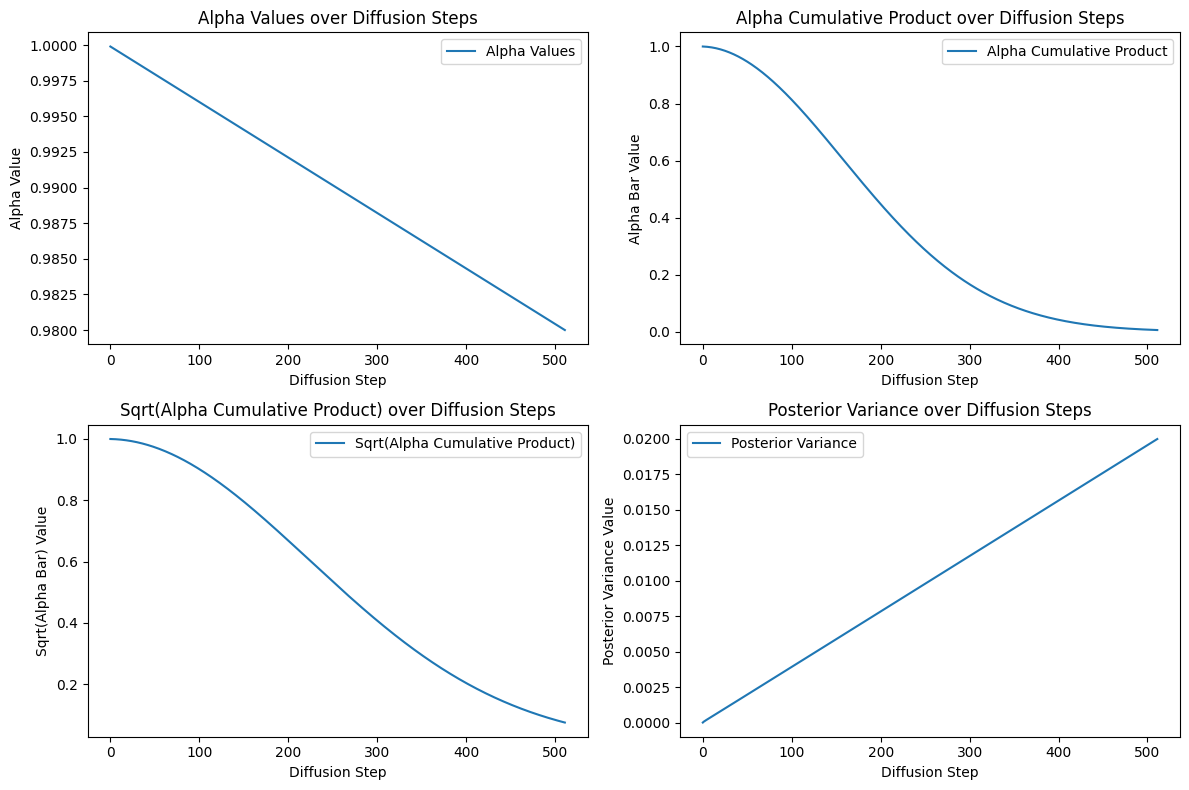

In [5]:
# Pre-calculate different terms for closed form
alphas = 1. - betas
# alpha bar
alphas_cumprod = torch.cumprod(alphas, axis=0)
# alpha bar at t-1
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
# sqrt of alpha bar
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

# Inference:
# 1 / sqrt(alpha)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
# sqrt of one minus alpha bar
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
# sigma_t
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Plotting the terms
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(T), alphas.numpy(), label='Alpha Values')
plt.xlabel('Diffusion Step')
plt.ylabel('Alpha Value')
plt.title('Alpha Values over Diffusion Steps')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(T), alphas_cumprod.numpy(), label='Alpha Cumulative Product')
plt.xlabel('Diffusion Step')
plt.ylabel('Alpha Bar Value')
plt.title('Alpha Cumulative Product over Diffusion Steps')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(T), sqrt_alphas_cumprod.numpy(), label='Sqrt(Alpha Cumulative Product)')
plt.xlabel('Diffusion Step')
plt.ylabel('Sqrt(Alpha Bar) Value')
plt.title('Sqrt(Alpha Cumulative Product) over Diffusion Steps')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(T), posterior_variance.numpy(), label='Posterior Variance')
plt.xlabel('Diffusion Step')
plt.ylabel('Posterior Variance Value')
plt.title('Posterior Variance over Diffusion Steps')
plt.legend()

plt.tight_layout()
plt.show()

Here we define two utility functions, one to visualize the forward diffusion process, and the other one to make an inference call on an existing DDPM:

# Forward Diffusion Visualization (forward_diffusion_viz)

This function visualizes the forward diffusion process, gradually transforming an input image into pure noise through a series of steps.

## Parameters:
- `image`: The original image to start the diffusion process with.
- `device`: Specifies the device (CPU or GPU) for tensor operations.
- `num_images`: Number of diffusion steps (images) to visualize.
- `dpi`: Dots per inch, controlling the quality of the displayed images.
- `interleave`: If True, interleaves the original noise used at each step with the diffused images.

## Process:
- Selects a subset of the total diffusion steps (T) based on num_images to visualize the transition from image to noise.
- For each selected step:
  - Generates random noise.
  - Combines the original image and noise according to the diffusion equations, using pre-calculated sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod for the specific time step.
  - Stores the processed images (and optionally the raw noise) for visualization.

## Visualization:
- Uses the `display_sequence` function to show the progression from the original image to noise.

# Reverse Sampling Algorithm (make_inference)

This function implements the reverse process of DDPM, where it starts from noise and reconstructs the data (image) by gradually denoising through the model's predictions.

## Parameters:
- `input_noise`: The initial noise to start the reverse diffusion from.
- `return_all`: If True, returns all intermediate images across the reverse diffusion steps.

## Process:
- Initializes the process with the input noise.
- Iterates backward through the diffusion steps from T to 1:
  - If not the final step, generates random noise for denoising; otherwise, sets noise to 0.
  - Calculates the reverse diffusion equation using the model's prediction for the current noise level, adjusting with the appropriate sqrt_recip_alphas, betas, and sqrt_one_minus_alphas_cumprod values.
  - Optionally, stores each intermediate image for visualization.

## Output:
- Returns the final reconstructed image or all intermediate images if return_all is set to True.

## Visualization:
- Uses the `display_sequence` function to visualize the progression from noise to the original image.

These functions are key for understanding and visualizing how DDPM works, illustrating both the forward process of adding noise to data and the reverse process of recovering the original data from noise using the model.


In [6]:
@torch.no_grad()
def forward_diffusion_viz(image, device='cpu', num_images=16, dpi=75, interleave=False):
    """
    Generate the forward sequence of noisy images taking the input image to pure noise
    """
    # Visualize only num_images diffusion steps, instead of all of them
    stepsize = int(T/num_images)
    
    imgs = []
    noises = []
    
    for i in range(0, T, stepsize):
        t = torch.full((1,), i, device=device, dtype=torch.long)

        # Forward diffusion process
        bs = image.shape[0]
        noise = torch.randn_like(image, device=device)
        img = (
            sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * image + 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
        )

        imgs.append(torch.clamp(img, -1, 1).squeeze(dim=0))
        noises.append(torch.clamp(noise, -1, 1).squeeze(dim=0))
    
    if interleave:
        imgs = [item for pair in zip(imgs, noises) for item in pair]
        
    fig = display_sequence(imgs, dpi=dpi)
    
    return fig, imgs[-1]


@torch.no_grad()
def make_inference(input_noise, return_all=False):
    """
    Implements the sampling algorithm from the DDPM paper
    """
    
    x = input_noise
    bs = x.shape[0]
    
    imgs = []
    
    # YOUR CODE HERE
    for time_step in range(0, T)[::-1]:
        
        noise = torch.randn_like(x) if time_step > 0 else 0
        
        t = torch.full((bs,), time_step, device=device, dtype=torch.long)
        
        # YOUR CODE HERE
        x = sqrt_recip_alphas[t].view(bs, 1, 1, 1) * (
            x - betas[t].view(bs, 1, 1, 1) * model(x, t) / 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1)
        ) + torch.sqrt(posterior_variance[t].view(bs, 1, 1, 1)) * noise
        
        imgs.append(torch.clamp(x, -1, 1))
    
    if return_all:
        return imgs
    else:
        return imgs[-1]
    
    return x

### Forward process

Let's now simulate our forward process. If everything went well, you should see a few images like this one:

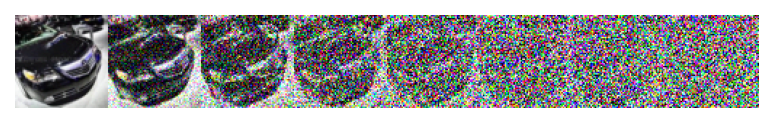

which show a few of the diffusion steps, from the original image to the left all the way to pure noise to the right.

This loop iterates through the first five images in a batch and applies the `forward_diffusion_viz` function to each. It visualizes the forward diffusion process for these images, showing how they are gradually transformed into pure noise through a selected number of diffusion steps. 

- `batch[:5]`: This slices the first five images from the batch for processing. Each image in the batch is expected to be a tensor representing an image.
- `image.unsqueeze(dim=0)`: Since the `forward_diffusion_viz` function expects the input image tensor to have a batch dimension, `unsqueeze(dim=0)` adds a batch dimension to the image tensor, effectively making it a batch of one image. This is necessary because the function performs operations that are designed to handle batches, even if the batch contains only a single image.
- `num_images=7`: This parameter specifies that the visualization should include 7 images from the forward diffusion process. Given that the total number of diffusion steps (T) is set earlier in the notebook, this parameter decides how to sample 7 steps evenly from the entire process to show the progression from the original image to noise.
- `dpi=150`: Sets the dots per inch (DPI) for the figure to 150, which affects the resolution of the output image. A higher DPI results in a higher-resolution visualization, making it clearer and more detailed.
- `interleave=False`: This indicates that the visualization should only include the diffused images, not interleaving them with the corresponding noise images used at each diffusion step. If `interleave` were `True`, the visualization would alternate between showing a diffused image and its corresponding noise image, providing insight into the noise patterns added at each step.

By running this loop, you will generate a series of visualizations for the first five images in the batch, each showing how the image is progressively noised through the diffusion process. This is a powerful way to understand visually how the diffusion model gradually transforms data into a noise distribution, a fundamental aspect of how DDPMs operate.

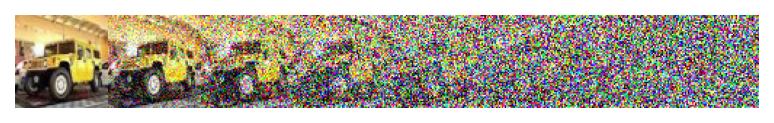

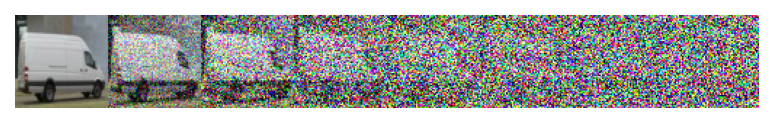

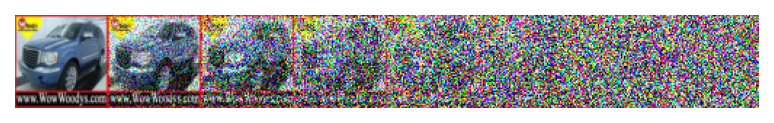

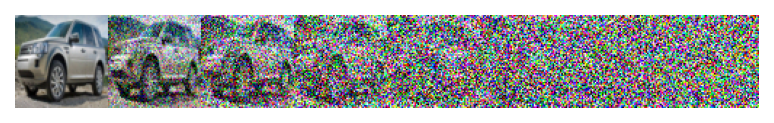

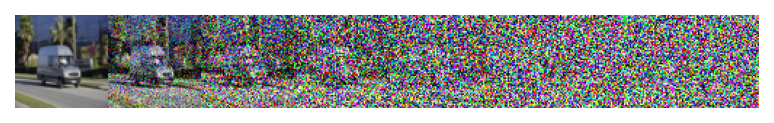

In [7]:
for image in batch[:5]:
    _ = forward_diffusion_viz(image.unsqueeze(dim=0), num_images=7, dpi=150, interleave=False)

## Training

### Model definition

Here we define the model we are going to train. We import a simple UNet model from the ``unet.py`` file (you can look into it if you like, but it is not required):

This code snippet introduces the creation of a U-Net model, which is a type of convolutional neural network commonly used for tasks that involve image-to-image prediction, such as image segmentation, image denoising, and in this context, for the Denoising Diffusion Probabilistic Models (DDPM). The U-Net model is defined in a separate file (`unet.py`), and here it's being instantiated for use, potentially in the DDPM's learning process. Let's dissect the key components:

### Importing the U-Net Model:
- `from unet import UNet`: This imports the UNet class definition from the `unet.py` file, making it available to be instantiated in this script.

### Instantiating the Model:
- `model = UNet(ch_mults=(1, 2, 1, 1))`: Creates an instance of the U-Net model. The `ch_mults` argument specifies the channel multiplier for each level of the U-Net architecture. In this case, the multipliers are `(1, 2, 1, 1)`, which means the number of channels will first increase and then stay constant in the deeper layers of the network. This setup could be tailored to balance between model capacity and computational efficiency.
- The commented line `model = UNet(ch_mults=(1, 2, 2, 2))` suggests an alternative configuration with a larger capacity, likely leading to potentially better performance at the cost of increased computational requirements. This setup indicates the flexibility of the U-Net architecture in adapting to different capacities depending on the complexity of the task and available computational resources.

### Printing Model Parameters:
- The loop iterates through all parameters of the model, printing their names and shapes. This is useful for debugging, understanding the model's architecture, and estimating its size. For instance, knowing the shape of each parameter tensor can help in understanding the connectivity and the data flow within the network, as well as calculating the total number of trainable parameters, which is an indicator of the model's capacity.

This snippet sets the stage for subsequent training or inference steps by initializing the U-Net model, which plays a central role in the denoising diffusion process by estimating the noise in each diffusion step, thereby enabling the reverse generation process from noise back to data.

In [8]:
from unet import UNet

# Assuming you have defined the UNet model correctly
model = UNet(ch_mults=(1, 2, 1, 1))

# Uncomment this if you want to do the _VERY_ long training,
# model = UNet(ch_mults=(1, 2, 2, 2))

# Print the parameters and their shapes
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")


Parameter: image_proj.weight, Shape: torch.Size([64, 3, 3, 3])
Parameter: image_proj.bias, Shape: torch.Size([64])
Parameter: time_emb.lin1.weight, Shape: torch.Size([256, 64])
Parameter: time_emb.lin1.bias, Shape: torch.Size([256])
Parameter: time_emb.lin2.weight, Shape: torch.Size([256, 256])
Parameter: time_emb.lin2.bias, Shape: torch.Size([256])
Parameter: down.0.res.norm1.weight, Shape: torch.Size([64])
Parameter: down.0.res.norm1.bias, Shape: torch.Size([64])
Parameter: down.0.res.conv1.weight, Shape: torch.Size([64, 64, 3, 3])
Parameter: down.0.res.conv1.bias, Shape: torch.Size([64])
Parameter: down.0.res.norm2.weight, Shape: torch.Size([64])
Parameter: down.0.res.norm2.bias, Shape: torch.Size([64])
Parameter: down.0.res.conv2.weight, Shape: torch.Size([64, 64, 3, 3])
Parameter: down.0.res.conv2.bias, Shape: torch.Size([64])
Parameter: down.0.res.time_emb.weight, Shape: torch.Size([64, 256])
Parameter: down.0.res.time_emb.bias, Shape: torch.Size([64])
Parameter: down.1.res.norm1

Our model has around 9.1 Million parameters. When compared to Stable Diffusion, which has 1 Billion parameters, it is very small! However, for this dataset, it can still give remarkable results.

### Training loop

Let's now do some preparation for the training loop. First we transfer the model as well as all our precomputed quantities to the GPU, so they can be used efficiently during training:

This code snippet prepares your model and tensors for training or inference by moving them to the appropriate computational device (GPU or CPU), ensuring optimal hardware utilization. Let's break it down:

### Determining the Device:
- `device = "cuda" if torch.cuda.is_available() else "cpu"`: This line checks if CUDA (GPU support) is available. If a GPU is available, it sets the device to "cuda"; otherwise, it falls back to using the CPU. Utilizing a GPU can significantly speed up model training and inference due to its parallel processing capabilities.

### Moving the Model to the Device:
- `model.to(device)`: Moves the U-Net model to the determined device. If the device is a GPU, this step ensures that all computations for the model are performed on the GPU, leveraging its computational power.

### Moving Tensors to the Device:
- Several tensors related to the diffusion process (such as `sqrt_alphas_cumprod`, `alphas`, `alphas_cumprod`, `alphas_cumprod_prev`, `sqrt_recip_alphas`, `sqrt_alphas_cumprod` again, `sqrt_one_minus_alphas_cumprod`, `posterior_variance`, and `betas`) are moved to the device. This is crucial because operations involving these tensors and the model need to be performed on the same device to avoid errors and ensure computational efficiency. The tensors contain pre-calculated values essential for the diffusion and reverse diffusion processes.

### Ensuring Consistency:
- It's important to have both the model and all input tensors on the same device to avoid cross-device data transfers, which are costly in terms of time and can lead to runtime errors. This step ensures that all components involved in computation are consistently located on the most appropriate hardware available.

This setup is a common practice in PyTorch applications, optimizing for computational efficiency and leveraging the available hardware to its fullest. It's particularly relevant for deep learning tasks like those involved in DDPMs, where the computational demand can be significant.

In [9]:
# Define the device based on GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model to the device
model.to(device)

# Move tensors to the device
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
alphas_cumprod_prev = alphas_cumprod_prev.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
posterior_variance = posterior_variance.to(device)
betas = betas.to(device)


Now we can define the loss we are going to minimize:

In [10]:
# Instantiate the Mean Squared Error (MSE) loss function
criterion = torch.nn.MSELoss()

This code snippet sets up the training hyperparameters, optimizer, learning rate scheduler, and visualizes the learning rate schedule for training a model, likely the U-Net model for the DDPM project previously discussed. Let's break down the key components:

### Hyperparameters Definition:
- `base_lr = 0.0006`: The maximum learning rate to be used by the optimizer. A learning rate is a hyperparameter that controls how much to adjust the model's weights in response to the estimated error each time the model weights are updated.
- `epochs = 10`: The total number of epochs for training, where one epoch equals one forward pass and one backward pass of all the training examples.
- `T_max = epochs`: The parameter for the Cosine Annealing scheduler, indicating the number of epochs for one cycle of learning rate adjustment.
- `warmup_epochs = 2`: The number of epochs at the beginning of training during which the learning rate is increased or "warmed up" before starting the cosine annealing.
- The commented lines suggest alternative values for a longer training regime, with a lower base learning rate, more epochs, and a longer warm-up period.

### Optimizer and Scheduler Setup:
#### Optimizer:
- An Adam optimizer is instantiated with the model's parameters and the specified base learning rate. Adam is a popular optimizer that combines the advantages of two other extensions of stochastic gradient descent, specifically Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).

#### Learning Rate Scheduler:
- A Cosine Annealing learning rate scheduler is defined with the optimizer, `T_max` adjusted for warm-up epochs, and a minimum learning rate set to a tenth of the base learning rate. Cosine Annealing adjusts the learning rate based on a cosine function, gradually decreasing it over epochs, which can lead to better convergence by fine-tuning the model as it approaches a minimum in the loss landscape.

### Learning Rate Schedule Visualization:
- The training loop simulates the scheduler's effect by stepping through each epoch, recording the current learning rate, and plotting these rates over the epochs. This visualization helps understand how the learning rate will change throughout the training process, providing insight into the training dynamics and allowing adjustments to the learning rate schedule if necessary.

This setup is crucial for effective model training, as it directly impacts the model's ability to learn from the data. A well-chosen learning rate and schedule can significantly improve training efficiency and model performance.




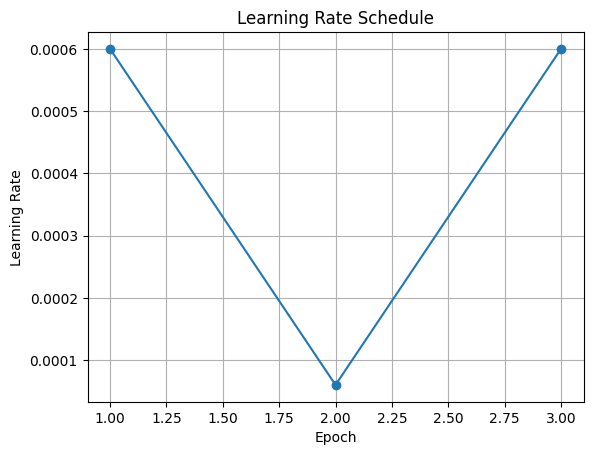

In [13]:
# Define hyperparameters
base_lr = 0.0006  # Maximum learning rate we will use
epochs = 10  # Total number of epochs
T_max = epochs  # Number of epochs for Cosine Annealing. We do only one cycle
warmup_epochs = 2  # Number of warm-up epochs

# Uncomment the following lines
# if you want to do the _VERY_ long training,
# base_lr = 0.0001  # Maximum learning rate we will use
# epochs = 300  # Total number of epochs
# T_max = epochs  # Number of epochs for Cosine Annealing. We do only one cycle
# warmup_epochs = 10  # Number of warm-up epochs

# Define optimizer
optimizer = Adam(model.parameters(), lr=base_lr)

# Define learning rate scheduler
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=T_max - warmup_epochs,
    eta_min=base_lr / 10  # Starting value for the LR
)

# Collect learning rates over epochs
learning_rates = []

for epoch in range(epochs):
    # Step the scheduler
    scheduler.step(epoch)
    # Get the current learning rate
    lr = optimizer.param_groups[0]['lr']
    # Append to the list of learning rates
    learning_rates.append(lr)

# Plot the learning rate schedule
plt.plot(range(1, epochs + 1), learning_rates, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()


Finally let's train! We train only for 5 epochs, which should mean around 20 min of training time. This won't get us to a good result, but you will see a few hints of cars appearing little by little.

This code snippet represents the final step of using the Denoising Diffusion Probabilistic Model (DDPM) to generate images. After training the model, this step involves creating new data (images) from random noise by reversing the diffusion process. Let's break it down:

### Generating Initial Noise:
- `input_noise = torch.randn((8, 3, IMG_SIZE, IMG_SIZE), device=device)`: This line generates a batch of 8 initial noise samples with the same shape as the input images to the model (3 channels, IMG_SIZE x IMG_SIZE pixels), ensuring they are on the correct computational device (GPU or CPU). The noise serves as the starting point for the reverse diffusion process.

### Making Inference (Reverse Diffusion):
- `imgs = make_inference(input_noise)`: The `make_inference` function is called with the initial noise. This function implements the reverse process of the DDPM, which iteratively refines the noise to produce images. The reverse process involves running the model multiple times, each step making the noise slightly more like data from the target distribution until it results in generated images.

### Displaying Generated Images:
- `_ = display_sequence(imgs, dpi=75, nrow=4)`: The generated images (`imgs`) are visualized using the `display_sequence` function, which arranges the images in a grid for easy viewing. The `dpi=75` parameter sets the resolution of the output figure, and `nrow=4` specifies that the grid should have 4 images per row. This visualization is crucial for evaluating the quality of the generated images and understanding the model's performance.

This process of generating images from noise showcases the capability of DDPMs to model complex data distributions and produce new samples from those distributions. The quality and diversity of the generated images are key indicators of the model's effectiveness and the success of the training process.


100%|██████████| 162/162 [02:47<00:00,  1.03s/it]


epoch 1: loss: 0.076, lr: 0.000300


100%|██████████| 162/162 [02:42<00:00,  1.00s/it]


epoch 2: loss: 0.055, lr: 0.000600


100%|██████████| 162/162 [02:41<00:00,  1.00it/s]


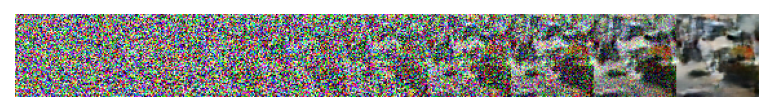

epoch 3: loss: 0.053, lr: 0.000060


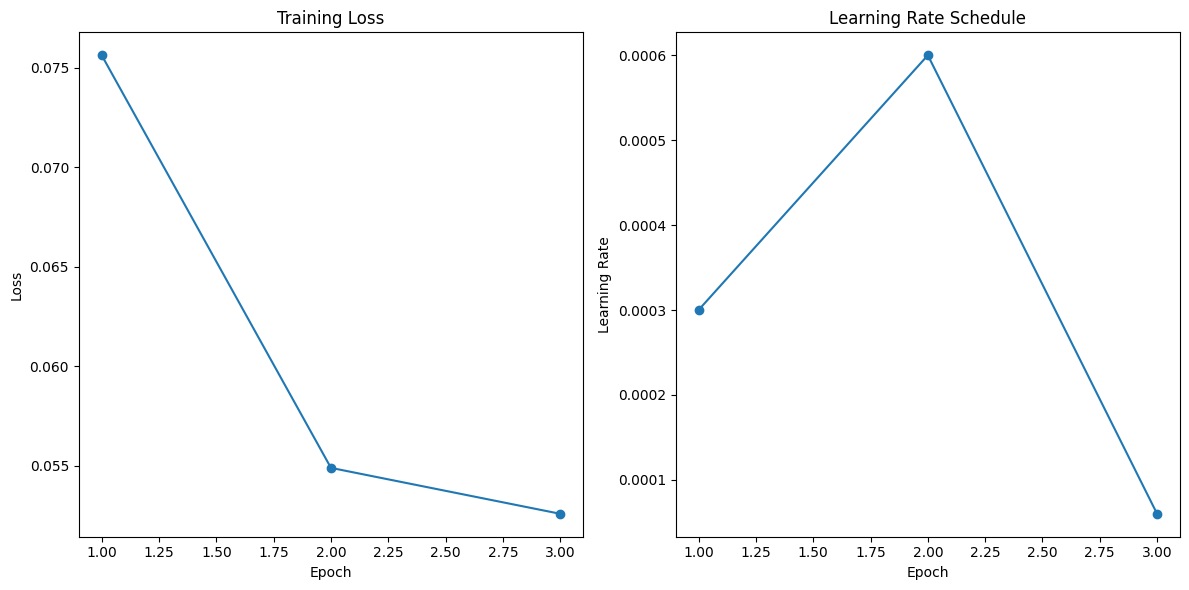

In [14]:


# Define the noise for generating images during training
fixed_noise = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)

# Smoothing factor for exponential moving average of the loss
alpha = 0.1  
ema_loss = None  # Initialize EMA loss

# Lists to store training progress for visualization
losses = []
learning_rates = []

# Training loop
for epoch in range(epochs):
    
    if epoch < warmup_epochs:
        # Linear warm-up
        lr = base_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    else:
        # Cosine Annealing after warm-up
        scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
        
    for batch, _ in tqdm(dataloader):
        
        batch = batch.to(device)
        bs = batch.shape[0]
        
        optimizer.zero_grad()
        
        # Sample diffusion time step
        t = torch.randint(0, T, (batch.shape[0],), device=device).long()
        
        # Generate targets for the UNet and apply them to the images
        noise = torch.randn_like(batch, device=device)
        x_noisy = (
            sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * batch + 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
        )
        
        noise_pred = model(x_noisy, t)
        loss = criterion(noise, noise_pred)
        
        loss.backward()
        optimizer.step()
        
        # Update exponential moving average of the loss
        if ema_loss is None:
            ema_loss = loss.item()
        else:
            ema_loss = alpha * loss.item() + (1 - alpha) * ema_loss
    
    # Append training progress for visualization
    losses.append(ema_loss)
    learning_rates.append(current_lr)
    
    # Generate images for visualization
    if epoch == epochs-1:
        with torch.no_grad():
            imgs = make_inference(fixed_noise, return_all=True)
            # Display the first and every 64th image (for variety)
            fig = display_sequence([imgs[0].squeeze(dim=0)] + [x.squeeze(dim=0) for x in imgs[63::64]], nrow=9, dpi=150)
            plt.show(fig)
        # Save the generated images
        os.makedirs("diffusion_output_long", exist_ok=True)
        fig.savefig(f"diffusion_output_long/frame_{epoch:05d}.png")
    
    # Print training progress
    print(f"epoch {epoch+1}: loss: {ema_loss:.3f}, lr: {current_lr:.6f}")

# Plot training progress
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), learning_rates, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.tight_layout()
plt.show()


## Inference

We can now have a look at what our model can produce:


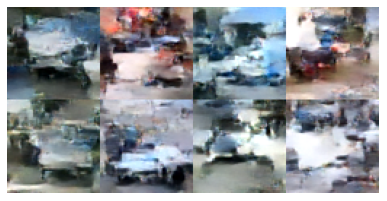

In [15]:
# YOUR CODE HERE
input_noise = torch.randn((8, 3, IMG_SIZE, IMG_SIZE), device=device)
imgs = make_inference(input_noise)
_ = display_sequence(imgs, dpi=75, nrow=4)

This is a fairly good result considering how small the model is and how little we trained it. We can already tell that it is indeed creating cars, with windshields and wheels, although it is still very early on. If we were to train for much longer, and/or use a larger model (for example, the one defined above in the commented lines has 55 Million parameters) and let it train for several hours, we would get something even better, like this:

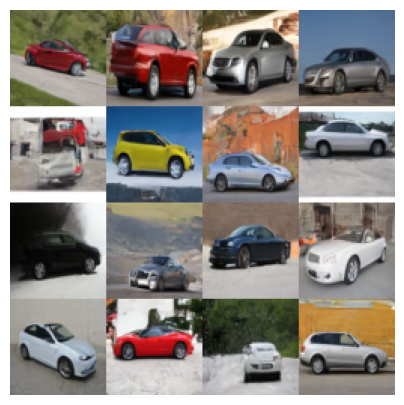